# Visualización de datos sobre COVID y vacunación

La web https://ourworldindata.org/, impulsada por la Universidad de Oxford, es un repositorio de datos contiene más de 3000 visualizaciones sobre casi 300 temáticas diversas. El apartado https://ourworldindata.org/covid-vaccinations contiene distintas comparativas entre países acerca de la indicencia de la enfermedad y el progreso de la vacunación. 



In [1]:
!pip install plotly==4.8 # Para tener la última versión de Plotly, necesaria para algunos apartados
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

     |████████████████████████████████| 11.5 MB 5.3 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


## Cargamos los datos

In [2]:
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv',sep=',')

Y nos quedamos con los datos a una determinada fecha. 

In [3]:
latest_data = df[df['date']=='2021-12-10']
# Con la siguiente línea elegiríamos la última fecha disponible, pero podría estar incompleta para muchos países. 
#latest_data = df[df['date']==df['date'].max()] 
latest_data.head()

iso_code  ... excess_mortality_cumulative_per_million
655        AFG  ...                                     NaN
1329  OWID_AFR  ...                                     NaN
1991       ALB  ...                                     NaN
2653       DZA  ...                                     NaN
3309       AND  ...                                     NaN

[5 rows x 67 columns]

## Población vacunada: diagramas de barras

¿Cuáles son los 20 países con mayor porcentaje de población vacunada?

In [4]:
sorted_data = (
    latest_data.dropna(subset=['people_vaccinated_per_hundred']) 
               .sort_values('people_vaccinated_per_hundred')
)
fig  = px.bar(sorted_data.iloc[-20:], x="people_vaccinated_per_hundred", y="location", orientation='h') # Mostramos los 20 primeros
fig.show()

Algunos países son realmente pequeños y no son representativos (sin mencionar que alguno tiene más del 100% de la población vacunada). ¿Cuáles son los 20 países, **con más de 1M de habitantes**, con mayor porcentaje de población vacunada?


In [5]:
filtered_data = sorted_data[sorted_data['population']>1e+6].dropna(subset=['continent'])
fig  = px.bar(filtered_data.iloc[-20:], x="people_vaccinated_per_hundred", y="location", orientation='h')
fig.show()

Mostremos el porcentaje de población vacunada junto a la población con pauta completa. 

In [6]:
fig  = px.bar(filtered_data.iloc[-20:], 
              x=["people_vaccinated_per_hundred","people_fully_vaccinated_per_hundred"], 
              y="location",
              barmode='group',
              orientation='h')
fig.show()

¿Podemos hacer una visualización más intuitiva que relacione el porcentaje de población vacunada con el de población con pauta completa?

Usemos agrupamiento de tipo *stacked* en lugar de *grouped*

In [6]:
# Primero añadimos una nueva columna con la diferencia entre vaccinated y fully_vaccinated
filtered_data['people_partially_vaccinated_per_hundred'] = filtered_data['people_vaccinated_per_hundred'] - \
                                                       filtered_data['people_fully_vaccinated_per_hundred'] 

In [7]:
fig  = px.bar(filtered_data.iloc[-20:], 
              x=["people_fully_vaccinated_per_hundred","people_partially_vaccinated_per_hundred"], 
              y="location",
              barmode='stack',
              orientation='h')
fig.show()

## Relación entre variables: *scatter plots*

Empezamos estudiando la relación entre el índice de desarrollo y el impacto de la pandemia

In [8]:
px.scatter(filtered_data,
           x='gdp_per_capita', 
           y='people_vaccinated_per_hundred',
           hover_name='location')

Es posible usar *seaborn* para visualizar un modelo de regresión entre ambas variables:

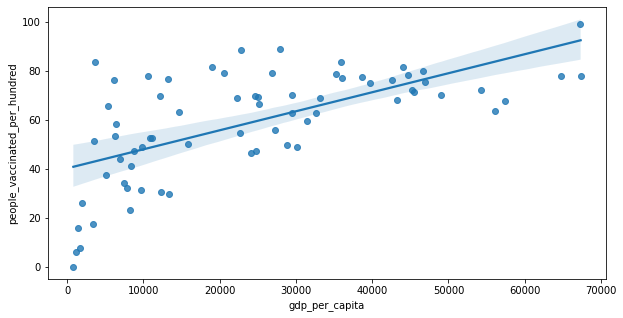

In [9]:
import seaborn as sns
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.regplot(x="gdp_per_capita", y="people_vaccinated_per_hundred", data=filtered_data,ax=ax)

Podemos apreciar que un modelo de regresión lineal sobre esa única variable (GDP) explica bastante bien el porcentaje de población vacunada

¿Y si quisiéramos plasmar también la población en el gráfico? ¿O los continentes a los que pertenecen los países?

## Más allá del scatter-plot: los *bubble charts*

Representamos la población en el tamaño de la burbuja y el continente en el color de la burbuja. 

In [11]:
px.scatter(filtered_data,
           x='gdp_per_capita', 
           y='people_vaccinated_per_hundred',
           size = 'population',
           color = 'continent',
           size_max=60,
           log_x = True,
           hover_name='location')

**Ejercicios:** 
1. Busque una visualización que muestre la relación entre el envejecimiento de la población con la gravedad de la pandemia en cada país. 
2. Analice con gráficos la relación entre la densidad de población de un país y la gravedad de la pandemia en el mismo. 

## Cómo mostrar información temporal

En esta ocasión volvemos al *dataframe* original para comparar la evolución de una determinada métrica sobre la gravedad de la pandemia a lo largo del tiempo. 

In [12]:
countries = ['Spain', 'United Kingdom', 'United States']
selected_data = df[df['location'].isin(countries)]

px.line(selected_data, x='date', y='new_cases_smoothed_per_million', color='location')

## Usando la variable temporal para una animación

**Ejercicio**. De forma similar a como se vio en la introducción, es posible representar la evolución de la pandemia con un gráfico animado. 

Para reducir la complejidad computacional se sugiere muestrear la escala temporal a la semana. 

## Cómo mostrar información espacial: mapas

Mostramos mapa-mundi con el color de los países representando el porcentaje de población vacunada. Los argumentos más importantes son:
* *locations*: la columna que contiene la información geográfica (códigos estandarizados que identifican al país).
* *color*: es la columna que contiene la maagnitud a representar. 
* *hover_name*: columna que contiene la información que queremos que muestre al sobrevolar cada país con el ratón.

In [13]:

fig = px.choropleth(latest_data, locations="iso_code",
                    color="people_vaccinated_per_hundred", 
                    hover_name="location", 
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()